In [5]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.font_manager

from sklearn.preprocessing import MinMaxScaler
from pyod.models.abod import ABOD
from pyod.models.knn import KNN
from pyod.models.cblof import CBLOF

In [ ]:
首先对skin数据进行离群点检测：

将多个csv文件进行拼接：

In [6]:
import os
import pandas as pd
# os.chdir("C:\\Users\\acer_pc\\Downloads\\skin_benchmarks\\skin\\benchmarks")
# data = pd.read_csv("skin_benchmark_0001.csv")
input_path='C:/Users/acer_pc/Downloads/skin_benchmarks/skin/benchmarks/'
files = os.listdir(input_path)
all_data_frames = []
n=1
for file in files:
    data_frame = pd.read_csv(input_path+file, index_col=None)
    all_data_frames.append(data_frame)
    n=n+1
    if n>9:
        break
 
data = pd.concat(all_data_frames, axis=0, ignore_index=True)

显示数据基本信息和直方图：

In [3]:
data.head()

,point.id,motherset,origin,original.label,diff.score,ground.truth,R,G,B
0,skin_point_117027,skin,binary,2,0.020405,nominal,-1.864336,-2.110524,-1.587289
1,skin_point_016927,skin,binary,1,0.000250,anomaly,0.384456,0.925785,1.747782
2,skin_point_240995,skin,binary,2,0.001285,nominal,-0.980882,-1.092860,-1.394351
3,skin_point_018861,skin,binary,1,0.000739,anomaly,-1.125447,-0.542320,0.383435
4,skin_point_087883,skin,binary,2,0.001053,nominal,-0.964819,-1.076177,-1.380570


count    24000.000000
mean         0.059736
std          0.124784
min          0.000000
25%          0.000844
50%          0.002793
75%          0.024863
max          1.000000
Name: diff.score, dtype: float64


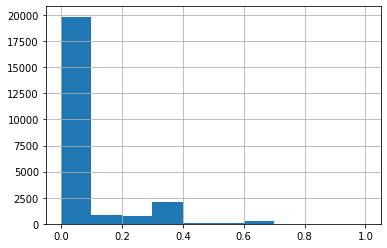

In [50]:
print(df['diff.score'].describe())
df['diff.score'].hist()

count    24000.000000
mean         0.489818
std          0.244267
min          0.000000
25%          0.266667
50%          0.545098
75%          0.690196
max          1.000000
Name: R, dtype: float64


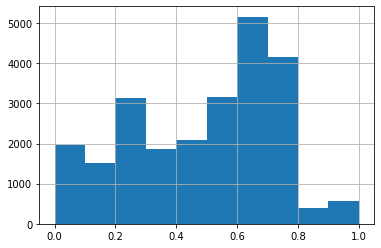

In [53]:
print(df.R.describe())
df['R'].hist()

count    24000.000000
mean         0.489818
std          0.244267
min          0.000000
25%          0.266667
50%          0.545098
75%          0.690196
max          1.000000
Name: R, dtype: float64


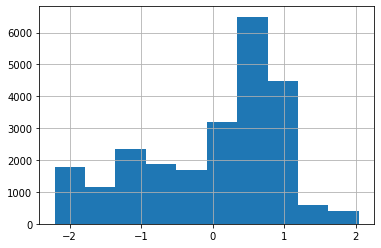

In [54]:
print(df.R.describe())
df['G'].hist()

count    24000.000000
mean         0.489818
std          0.244267
min          0.000000
25%          0.266667
50%          0.545098
75%          0.690196
max          1.000000
Name: R, dtype: float64


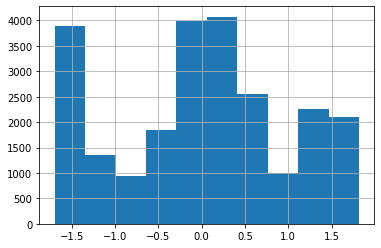

In [55]:
print(df.R.describe())
df['B'].hist()

从直方图可看出diff score的分布集中于左侧，而RGB数据的分布范围较广

下面使用KNN算法分别对diffscore和RGB数据进行离群点检测：

In [24]:
def outlier_detect(data,name1,name2):
    minmax = MinMaxScaler(feature_range=(0, 1))
    df = data.dropna()
    df[[name1,name2]] = minmax.fit_transform(df[[name1,name2]])
    
    #将Sales和Profit合并成一个两列的numpy数组
    X1 = df[name1].values.reshape(-1,1)
    X2 = df[name2].values.reshape(-1,1)
    X = np.concatenate((X1,X2),axis=1)
    
     
    #设定异常值比例
    outliers_fraction = 0.01
    xx , yy = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
     
    #定义KNN模型
    clf = KNN(contamination=outliers_fraction)
     
    #训练数据
    clf.fit(X)
    # 预测异常值分数
    scores_pred = clf.decision_function(X) * -1
            
    # 预测异常值和正常值的数据
    y_pred = clf.predict(X)
    n_inliers = len(y_pred) - np.count_nonzero(y_pred)
    n_outliers = np.count_nonzero(y_pred == 1)
     
    plt.figure(figsize=(8, 8))
     
    df1 = df
    df1['outlier'] = y_pred.tolist()
        
    #过滤出Sales和Profit的正常值
    inliers_1 = np.array(df1[name1][df1['outlier'] == 0]).reshape(-1,1)
    inliers_2 = np.array(df1[name2][df1['outlier'] == 0]).reshape(-1,1)
    # inliers_B = np.array(df1['B'][df1['outlier'] == 0]).reshape(-1,1)
        
    #过滤出Sales和Profit的异常值
    outliers_1 = df1[name1][df1['outlier'] == 1].values.reshape(-1,1)
    outliers_2 = df1[name2][df1['outlier'] == 1].values.reshape(-1,1)
    # outliers_B = df1['B'][df1['outlier'] == 1].values.reshape(-1,1)
         
    print('异常值数量:',n_outliers,'正常值数量:',n_inliers)
            
    # 设定一个阈值用以识别正常值和异常值的标准
    threshold = np.percentile(scores_pred, 100 * outliers_fraction)
            
    #决策函数为每一个数据点计算异常值分数
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
    Z = Z.reshape(xx.shape)
    #在图上对从最小的异常值分数到阈值的范围内进行分层着色
    plt.contourf(xx, yy, Z, levels=[threshold, Z.max()],colors='orange')
            
    #在异常值分数等于阈值处画红色线条
    a = plt.contour(xx, yy, Z, levels=[threshold],linewidths=2, colors='red')
            
    #填充橙色轮廓线，其中异常分数的范围是从阈值到最大异常分数
    plt.contourf(xx, yy, Z, levels=[threshold, Z.max()],colors='orange')
    b = plt.scatter(inliers_1, inliers_2, c='white',s=20, edgecolor='k')
        
    c = plt.scatter(outliers_1, outliers_2, c='black',s=20, edgecolor='k')
           
    plt.axis('tight')   
    plt.legend([a.collections[0], b,c], ['decision function', 'inlier','outlier'],
           prop=matplotlib.font_manager.FontProperties(size=20),loc='lower right')
      
    plt.xlim((0, 1))
    plt.ylim((0, 1))
    plt.title('KNN(K-Nearest Neighbor)')
    plt.show();


D:\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
D:\anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
D:\anaconda3\lib\site-packages\ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

异常值数量: 163 正常值数量: 23837


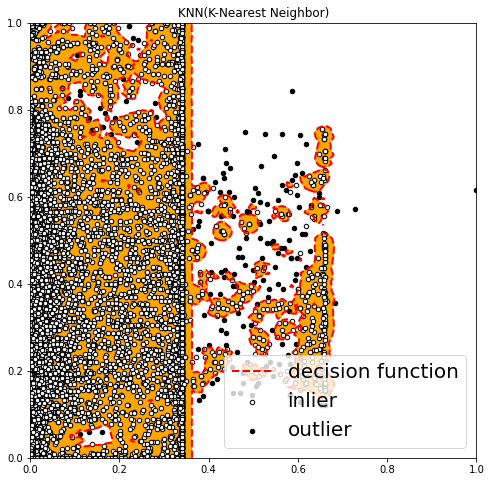

In [25]:
outlier_detect(data,'diff.score','R')

D:\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
D:\anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
D:\anaconda3\lib\site-packages\ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

异常值数量: 164 正常值数量: 23836


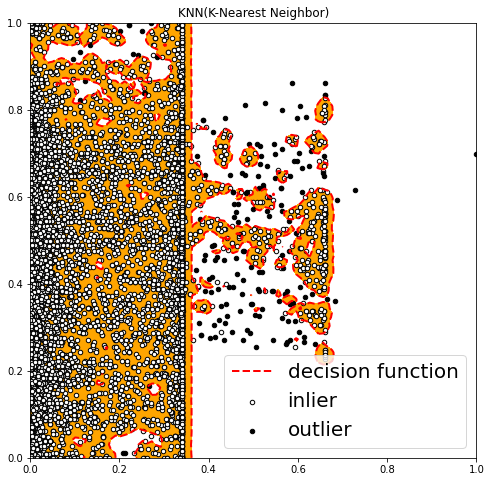

In [26]:
outlier_detect(data,'diff.score','G')

D:\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
D:\anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
D:\anaconda3\lib\site-packages\ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

异常值数量: 163 正常值数量: 23837


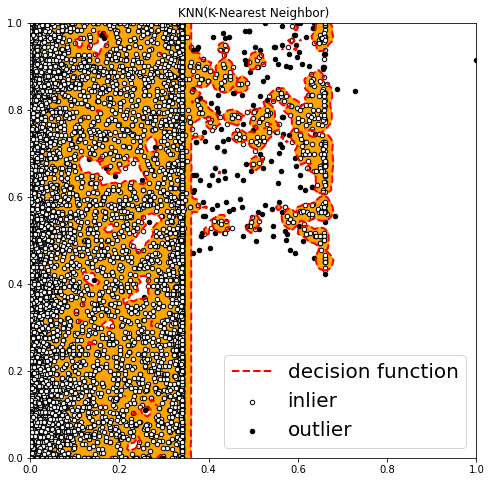

In [27]:
outlier_detect(data,'diff.score','B')

可以看出RGB数据相对于diff score集中于左侧，离群点多出现于右侧。

然后对pageb数据进行离群点检测：

将多个csv文件进行拼接：

In [11]:
input_path='C:/Users/acer_pc/Downloads/pageb_benchmarks/pageb/benchmarks/'
files = os.listdir(input_path)
all_data_frames = []
n=1
for file in files:
    data_frame = pd.read_csv(input_path+file, index_col=None)
    all_data_frames.append(data_frame)
    n=n+1
    if n>9:
        break
 
data_ = pd.concat(all_data_frames, axis=0, ignore_index=True)

显示数据基本信息和直方图：

In [12]:
data_.head()

,point.id,motherset,origin,original.label,diff.score,ground.truth,V,V.1,V.2,V.3,V.4,V.5,V.6,V.7,V.8,V.9,noise..1,noise..2,noise..3,noise..4
0,pageb_point_2739,pageb,multiclass,1,0.021586,nominal,-0.024959,-0.719726,-0.232691,-0.425159,-0.223015,1.177463,-0.064409,-0.269953,-0.357219,-0.559822,NaN,NaN,NaN,NaN
1,pageb_point_0048,pageb,multiclass,2,0.010946,anomaly,-0.446887,-0.588975,-0.238052,-0.089695,1.892235,0.462597,0.134349,-0.263656,-0.373695,-0.625569,NaN,NaN,NaN,NaN
2,pageb_point_0980,pageb,multiclass,1,0.026369,nominal,-0.183182,-0.379773,-0.180725,-0.233945,-0.363657,1.042693,-0.052683,-0.210914,-0.229130,-0.410397,NaN,NaN,NaN,NaN
3,pageb_point_0743,pageb,multiclass,2,0.005276,anomaly,-0.499628,-0.632559,-0.243620,0.105721,2.229775,1.259497,0.004064,-0.277825,-0.384856,-0.625569,NaN,NaN,NaN,NaN
4,pageb_point_1408,pageb,multiclass,1,0.030725,nominal,-0.024959,0.090931,-0.040914,-0.122264,-0.881218,-0.486652,-0.069041,-0.121174,-0.020786,0.235117,NaN,NaN,NaN,NaN


count    39807.000000
mean        -0.000976
std          0.947721
min         -0.499628
25%         -0.183182
50%         -0.130441
75%         -0.024959
max         41.851433
Name: V, dtype: float64


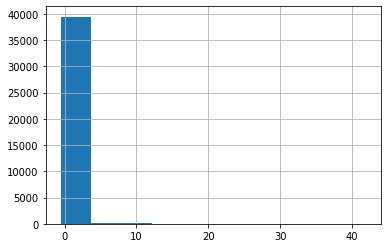

In [13]:
print(data_['V'].describe())
data_['V'].hist()

count    39807.000000
mean         0.000825
std          1.002157
min         -0.772027
25%         -0.632559
50%         -0.423357
75%          0.151948
max          4.039615
Name: V.1, dtype: float64


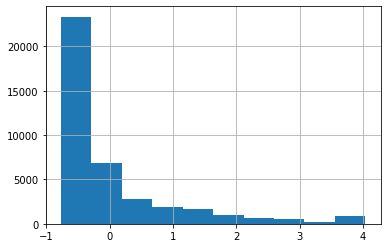

In [14]:
print(data_['V.1'].describe())
data_['V.1'].hist()

count    39807.000000
mean         0.003589
std          1.041095
min         -0.245682
25%         -0.224030
50%         -0.180725
75%         -0.045038
max         29.445967
Name: V.2, dtype: float64


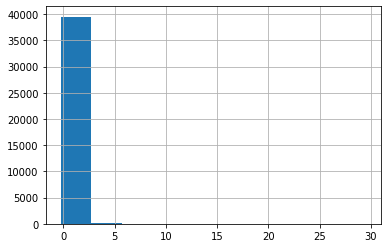

In [15]:
print(data_['V.2'].describe())
data_['V.2'].hist()

count    39807.000000
mean         0.003630
std          1.011747
min         -0.447730
25%         -0.378162
50%         -0.280454
75%         -0.004201
max         17.041770
Name: V.3, dtype: float64


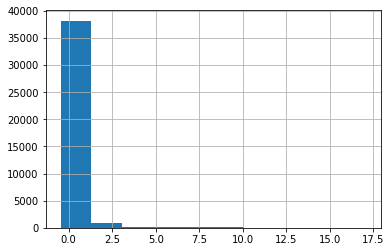

In [16]:
print(data_['V.3'].describe())
data_['V.3'].hist()

count    39807.000000
mean         0.001410
std          1.000753
min         -1.781324
25%         -0.605560
50%         -0.172384
75%          0.322675
max          3.551806
Name: V.4, dtype: float64


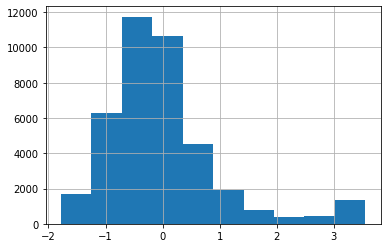

In [17]:
print(data_['V.4'].describe())
data_['V.4'].hist()

count    39807.000000
mean         0.001910
std          1.000046
min         -4.236770
25%         -0.621422
50%          0.111023
75%          0.831749
max          1.259497
Name: V.5, dtype: float64


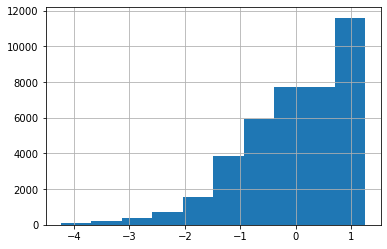

In [18]:
print(data_['V.5'].describe())
data_['V.5'].hist()

count    39807.000000
mean         0.001729
std          1.046285
min         -0.075555
25%         -0.066869
50%         -0.060066
75%         -0.046603
max         71.639416
Name: V.6, dtype: float64


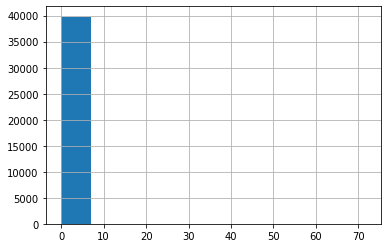

In [19]:
print(data_['V.6'].describe())
data_['V.6'].hist()

count    39807.000000
mean         0.002047
std          1.018117
min         -0.282549
25%         -0.254997
50%         -0.203829
75%         -0.064495
max         25.702762
Name: V.7, dtype: float64


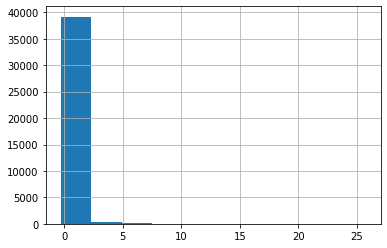

In [20]:
print(data_['V.7'].describe())
data_['V.7'].hist()

count    39807.000000
mean         0.002600
std          1.024042
min         -0.390171
25%         -0.343400
50%         -0.262082
75%         -0.012547
max         24.125319
Name: V.8, dtype: float64


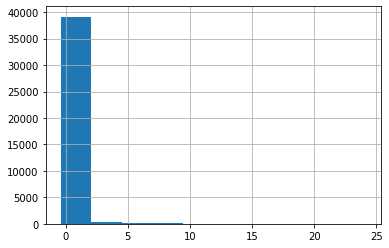

In [21]:
print(data_['V.8'].describe())
data_['V.8'].hist()

count    39807.000000
mean         0.001162
std          1.016840
min         -0.631546
25%         -0.535914
50%         -0.350627
75%          0.109601
max         18.560561
Name: V.9, dtype: float64


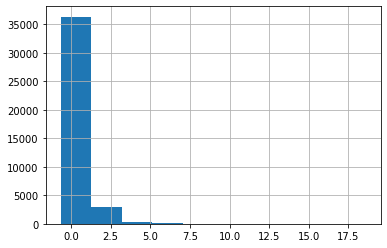

In [22]:
print(data_['V.9'].describe())
data_['V.9'].hist()

从直方图可以看出10个不同的V值除V1 V4 V5以外都集中于左侧

下面使用KNN算法进行离群点检测：

D:\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
D:\anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
D:\anaconda3\lib\site-packages\ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

异常值数量: 169 正常值数量: 17523


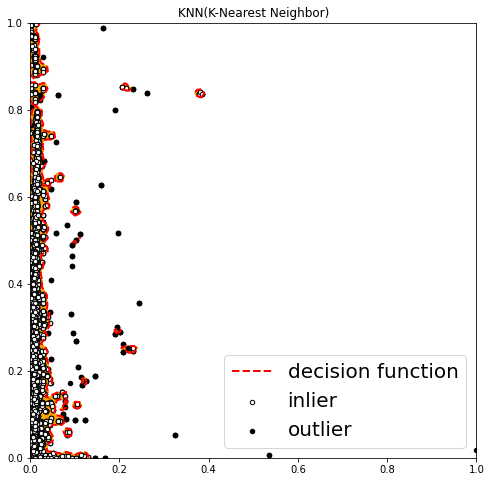

In [28]:
outlier_detect(data_,'V','V.1')

D:\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
D:\anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
D:\anaconda3\lib\site-packages\ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

异常值数量: 171 正常值数量: 17521


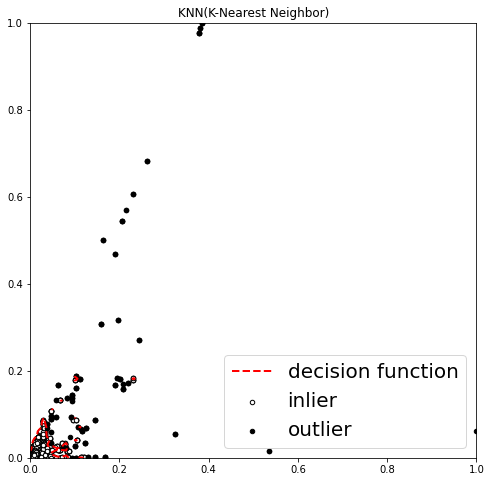

In [29]:
outlier_detect(data_,'V','V.2')

D:\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
D:\anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
D:\anaconda3\lib\site-packages\ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

异常值数量: 165 正常值数量: 17527


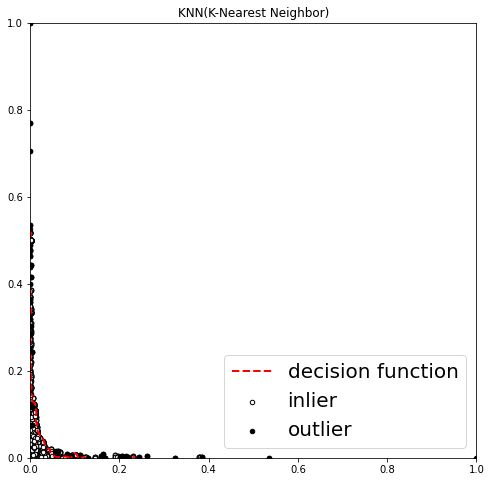

In [30]:
outlier_detect(data_,'V','V.3')

D:\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
D:\anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
D:\anaconda3\lib\site-packages\ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

异常值数量: 169 正常值数量: 17523


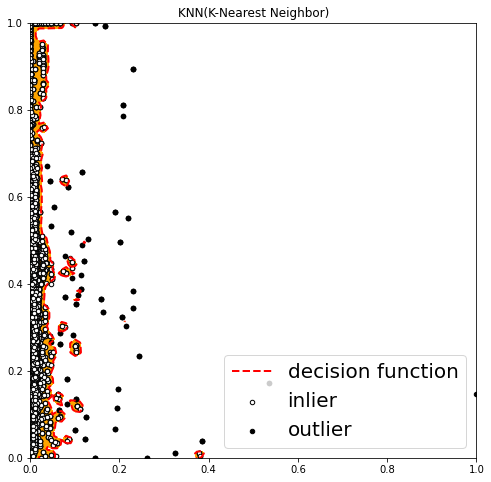

In [31]:
outlier_detect(data_,'V','V.4')

D:\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
D:\anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
D:\anaconda3\lib\site-packages\ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

异常值数量: 165 正常值数量: 17527


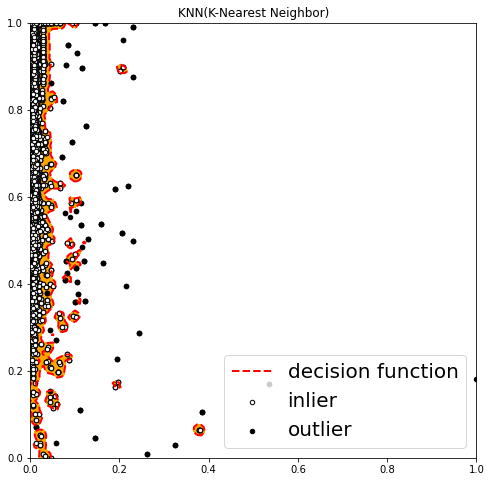

In [32]:
outlier_detect(data_,'V','V.5')

D:\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
D:\anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
D:\anaconda3\lib\site-packages\ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

异常值数量: 172 正常值数量: 17520


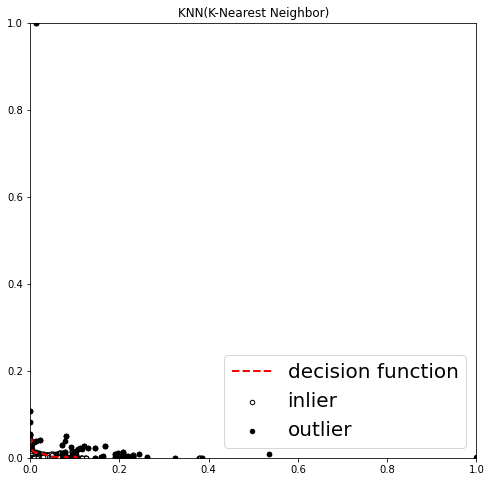

In [33]:
outlier_detect(data_,'V','V.6')

D:\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
D:\anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
D:\anaconda3\lib\site-packages\ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

异常值数量: 172 正常值数量: 17520


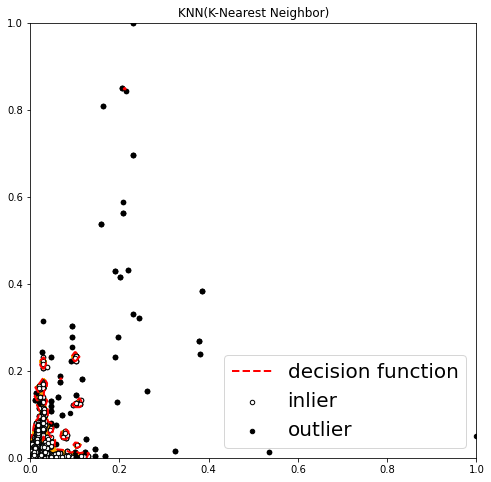

In [34]:
outlier_detect(data_,'V','V.7')

D:\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
D:\anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
D:\anaconda3\lib\site-packages\ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

异常值数量: 171 正常值数量: 17521


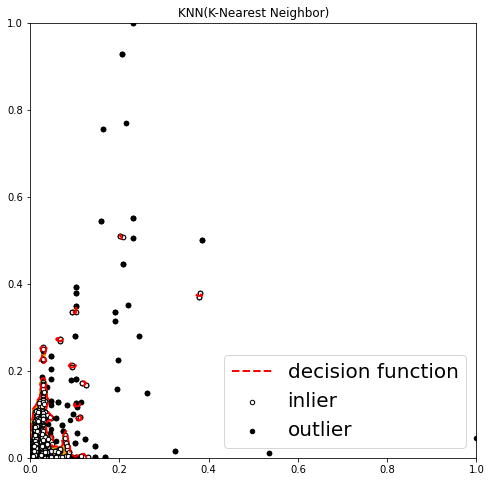

In [35]:
outlier_detect(data_,'V','V.8')

D:\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
D:\anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
D:\anaconda3\lib\site-packages\ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

异常值数量: 169 正常值数量: 17523


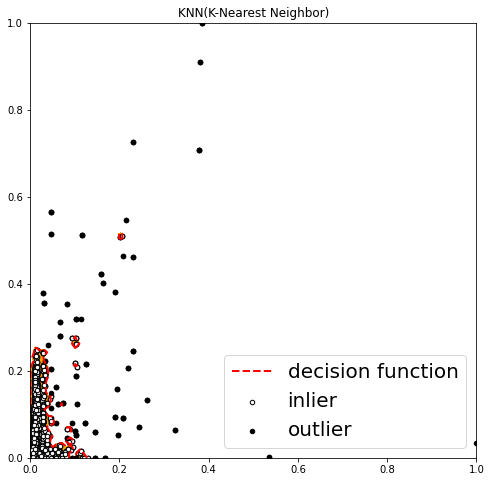

In [36]:
outlier_detect(data_,'V','V.9')

以上结果分别是V1至V9和V的离群点检测，可见V1，V4，V5的群内点分布于左侧；其他各项数据的群内点分布于左下角。这与直方图所示数据分布是相一致的。